In [ ]:
!pip install --upgrade -q transformers datasets
!pip install --upgrade pyarrow
!pip install evaluate
!pip install transformers[torch]
!pip install torch

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from evaluate import load
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
data = load_dataset('csv', data_files='train.csv', split='train')
data

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
    num_rows: 12120
})

In [ ]:
df = data.to_pandas()

train_df, val_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df[['label', 'lang_abv']]
)

In [ ]:
def display_pair_of_sentence(x):
    print( "Premise : " + x['premise'])
    print( "Hypothesis: " + x['hypothesis'])
    print( "Language: " + x['language'])
    print( "Label: " + str(x['label']))
    print()

df.head(5).apply(lambda x : display_pair_of_sentence(x), axis=1)

df.shape

Premise : and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Language: English
Label: 0

Premise : These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Language: English
Label: 2

Premise : Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Hypothesis: J'essayais d'accomplir quelque chose.
Language: French
Label: 0

Premise : you know they can't really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: They can't defend themselves because of their age.
Language: English
Label: 0

Premise : ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Hypothesis: เด็กสามารถเห็นได้ว่าชาติพันธุ

(12120, 6)

In [ ]:
df[['premise', 'hypothesis', 'lang_abv', 'language']].describe()

,premise,hypothesis,lang_abv,language
count,12120,12120,12120,12120
unique,8209,12119,15,15
top,I had an additional reason for that belief in ...,I am not sure.,en,English
freq,3,2,6870,6870


In [ ]:
df[['lang_abv', 'language']].value_counts()

,,count
lang_abv,language,
en,English,6870
zh,Chinese,411
ar,Arabic,401
fr,French,390
sw,Swahili,385
ur,Urdu,381
vi,Vietnamese,379
ru,Russian,376
hi,Hindi,374


In [ ]:
df.isna().sum()

,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0


<ipython-input-17-62097f2b183f>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])


Text(0.5, 1.0, 'Distribution of labels in the training set')

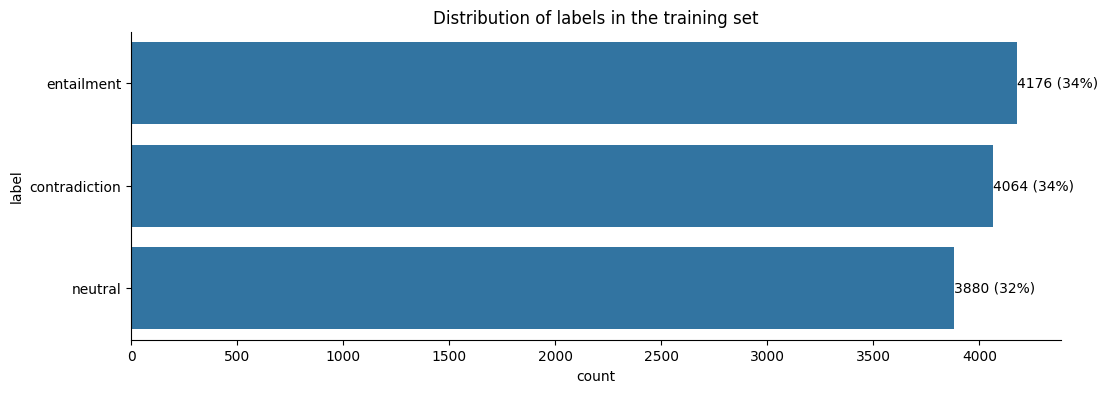

In [ ]:
RESULT_DICT = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 4))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df,
                   y="label",
                   order = df['label'].value_counts().index)

abs_values = df['label'].value_counts(ascending=False)
rel_values = df['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

Text(0.5, 1.0, 'Distribution of languages in the training set')

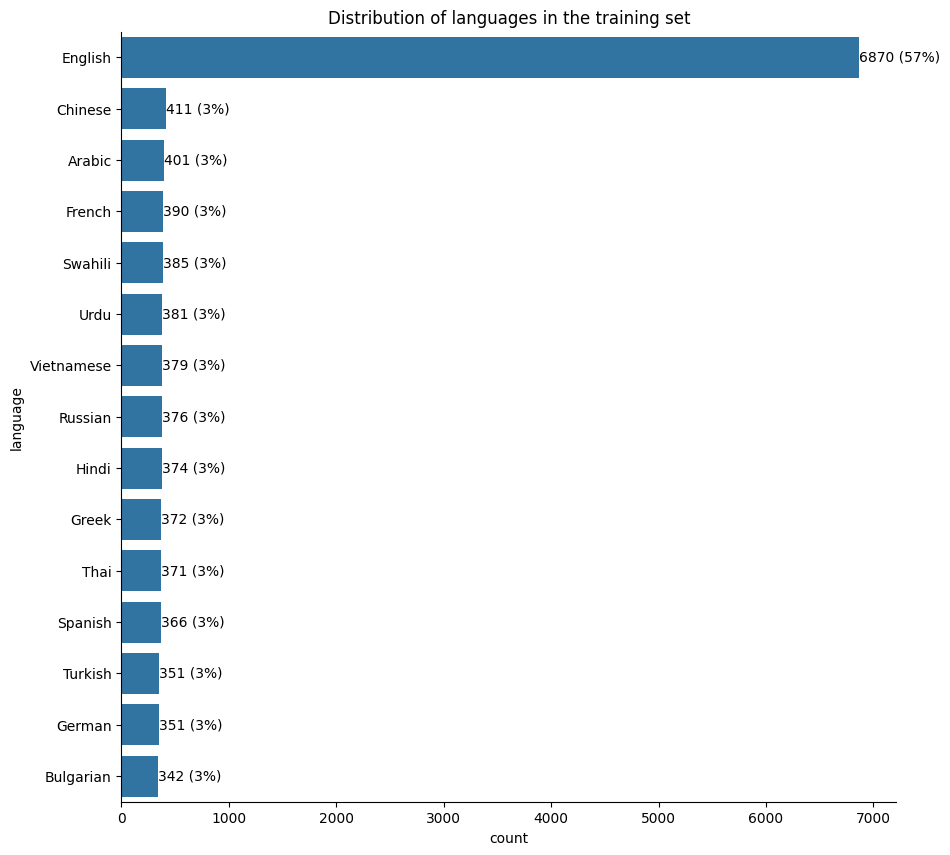

In [ ]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df,
                   y="language",
                   order = df['language'].value_counts().index)

abs_values = df['language'].value_counts(ascending=False)
rel_values = df['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

In [ ]:
# Train, Validation data spliting
data_split = data.train_test_split(0.2)

data_dict = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'val': Dataset.from_pandas(val_df),
    'test':load_dataset('csv', data_files='test.csv', split='train')
})

data_dict

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__'],
        num_rows: 8484
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__'],
        num_rows: 3636
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [ ]:

english_train = [sample for sample in data_dict['train'] if sample['lang_abv'] == 'en']
english_val = [sample for sample in data_dict['val'] if sample['lang_abv'] == 'en']
english_test = [sample for sample in data_dict['test'] if sample['lang_abv'] == 'en']

multilingual_train = [sample for sample in data_dict['train'] if sample['lang_abv'] != 'en']
multilingual_val = [sample for sample in data_dict['val'] if sample['lang_abv'] != 'en']
multilingual_test = [sample for sample in data_dict['test'] if sample['lang_abv'] != 'en']

english_data_dict = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(english_train)),
    'val': Dataset.from_pandas(pd.DataFrame(english_val)),
    'test': Dataset.from_pandas(pd.DataFrame(english_test))
})

multilingual_data_dict = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(multilingual_train)),
    'val': Dataset.from_pandas(pd.DataFrame(multilingual_val)),
    'test': Dataset.from_pandas(pd.DataFrame(multilingual_test))
})

print("English DataDict:")
print(english_data_dict)

print("\nMultilingual DataDict:")
print(multilingual_data_dict)

English DataDict:
DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__'],
        num_rows: 4809
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__'],
        num_rows: 2061
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 2945
    })
})

Multilingual DataDict:
DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__'],
        num_rows: 3675
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__'],
        num_rows: 1575
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 2250
    })
})


In [ ]:

english_checkpoint = "sileod/deberta-v3-base-tasksource-nli"
english_tokenizer = AutoTokenizer.from_pretrained(english_checkpoint, truncation=True)
english_model = AutoModelForSequenceClassification.from_pretrained(english_checkpoint, num_labels=3)

multilingual_checkpoint = 'MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7'
multilingual_tokenizer = AutoTokenizer.from_pretrained(multilingual_checkpoint, truncation=True)
multilingual_model = AutoModelForSequenceClassification.from_pretrained(multilingual_checkpoint, num_labels=3)

data_collator = DataCollatorWithPadding(tokenizer=multilingual_tokenizer)
print("English model:")
print(english_model)

print("\nMultilingual model:")
print(multilingual_model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

English model:
DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [ ]:
def preprocess_data(batch, tokenizer):
    batch['text'] = [x1 + f' {tokenizer.sep_token} ' + x2 for x1, x2 in zip(batch['premise'], batch['hypothesis'])]
    tokenized_output = tokenizer(batch['text'], truncation=True, padding=True)
    batch.update(tokenized_output)
    return tokenizer(batch['text'])

english_data_dict = english_data_dict.map(lambda batch: preprocess_data(batch, english_tokenizer), batched=True)

multilingual_data_dict = multilingual_data_dict.map(lambda batch: preprocess_data(batch, multilingual_tokenizer), batched=True)

print("English DataDict after preprocessing:")
print(english_data_dict)

print("\nMultilingual DataDict after preprocessing:")
print(multilingual_data_dict)

Map:   0%|          | 0/4809 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2061 [00:00<?, ? examples/s]

Map:   0%|          | 0/2945 [00:00<?, ? examples/s]

Map:   0%|          | 0/3675 [00:00<?, ? examples/s]

Map:   0%|          | 0/1575 [00:00<?, ? examples/s]

Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

English DataDict after preprocessing:
DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4809
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2061
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2945
    })
})

Multilingual DataDict after preprocessing:
DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3675
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis',

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate multiple metrics
    accuracy = load("accuracy").compute(predictions=predictions, references=labels)
    f1 = load("f1").compute(predictions=predictions, references=labels, average="macro")
    precision = load("precision").compute(predictions=predictions, references=labels, average="macro")
    recall = load("recall").compute(predictions=predictions, references=labels, average="macro")

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"]
    }

eng_train_args = TrainingArguments(
    output_dir='results',
    logging_dir='logs',
    report_to=[],

    evaluation_strategy='steps',
    eval_steps=125,
    logging_steps=125,
    save_steps=125,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,

    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=3,
)

mul_train_args = TrainingArguments(
    output_dir='results',
    logging_dir='logs',
    report_to=[],

    evaluation_strategy='steps',
    eval_steps=125,
    logging_steps=125,
    save_steps=125,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,

    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=3,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
multilingual_trainer = Trainer(
    model=multilingual_model,
    args=mul_train_args,
    train_dataset=multilingual_data_dict['train'],
    eval_dataset=multilingual_data_dict['val'],
    tokenizer=multilingual_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)]
)

multilingual_trainer.train()

<ipython-input-37-7804d3fb8474>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  multilingual_trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,0.119700,0.763260,0.850794,0.851258,0.855170,0.850975
250,0.402300,0.567519,0.850159,0.850488,0.855706,0.850200
375,0.157600,0.687471,0.848254,0.848252,0.851127,0.848076
500,0.130100,0.810637,0.852063,0.852492,0.856728,0.852202
625,0.071700,0.891580,0.857778,0.858451,0.862764,0.857970
750,0.066100,0.886375,0.855873,0.855941,0.858639,0.855751
875,0.034800,0.909342,0.860317,0.860410,0.861851,0.860216
1000,0.020900,0.927374,0.859048,0.859210,0.860384,0.858999
1125,0.017600,0.952545,0.860952,0.861068,0.863177,0.860896


TrainOutput(global_step=1150, training_loss=0.11127655532049097, metrics={'train_runtime': 1366.306, 'train_samples_per_second': 13.449, 'train_steps_per_second': 0.842, 'total_flos': 967660114136040.0, 'train_loss': 0.11127655532049097, 'epoch': 5.0})

In [ ]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
english_trainer = Trainer(
    model=english_model,
    args=eng_train_args,
    train_dataset=english_data_dict['train'],
    eval_dataset=english_data_dict['val'],
    tokenizer=english_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)]
)

english_trainer.train()

<ipython-input-39-3430a68803cf>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  english_trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,0.054400,0.401874,0.908297,0.907937,0.908124,0.908302


KeyboardInterrupt: 

In [ ]:
english_preds = english_trainer.predict(english_data_dict['test'])
multilingual_preds = multilingual_trainer.predict(multilingual_data_dict['test'])

AttributeError: `AcceleratorState` object has no attribute `distributed_type`. This happens if `AcceleratorState._reset_state()` was called and an `Accelerator` or `PartialState` was not reinitialized.

In [ ]:
print(english_preds)
print('-')
print(multilingual_preds)

PredictionOutput(predictions=array([[-2.25      ,  1.3203125 ,  1.4072266 ],
       [-1.8867188 ,  4.8242188 , -2.1582031 ],
       [-1.1865234 ,  4.3789062 , -2.3574219 ],
       ...,
       [-3.328125  , -0.11889648,  3.4765625 ],
       [ 3.5605469 , -2.2207031 , -2.4726562 ],
       [-2.4160156 , -2.3105469 ,  5.4101562 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 6.5111, 'test_samples_per_second': 452.306, 'test_steps_per_second': 28.413})
-
PredictionOutput(predictions=array([[-1.3359375 , -2.1835938 ,  3.5605469 ],
       [-1.2207031 ,  3.5917969 , -1.6240234 ],
       [ 3.2578125 ,  0.05392456, -3.2382812 ],
       ...,
       [ 3.2851562 , -0.5180664 , -2.8007812 ],
       [ 1.734375  ,  0.2088623 , -2.0097656 ],
       [ 2.1582031 , -0.16015625, -2.1015625 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 5.765, 'test_samples_per_second': 390.286, 'test_steps_per_second': 24.458})


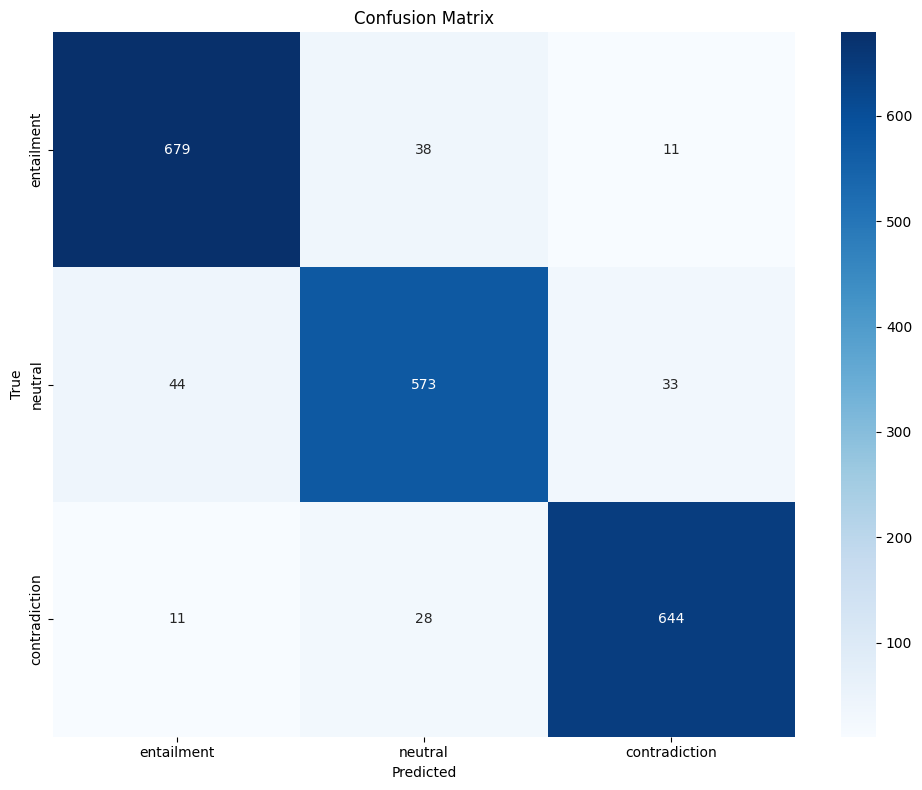

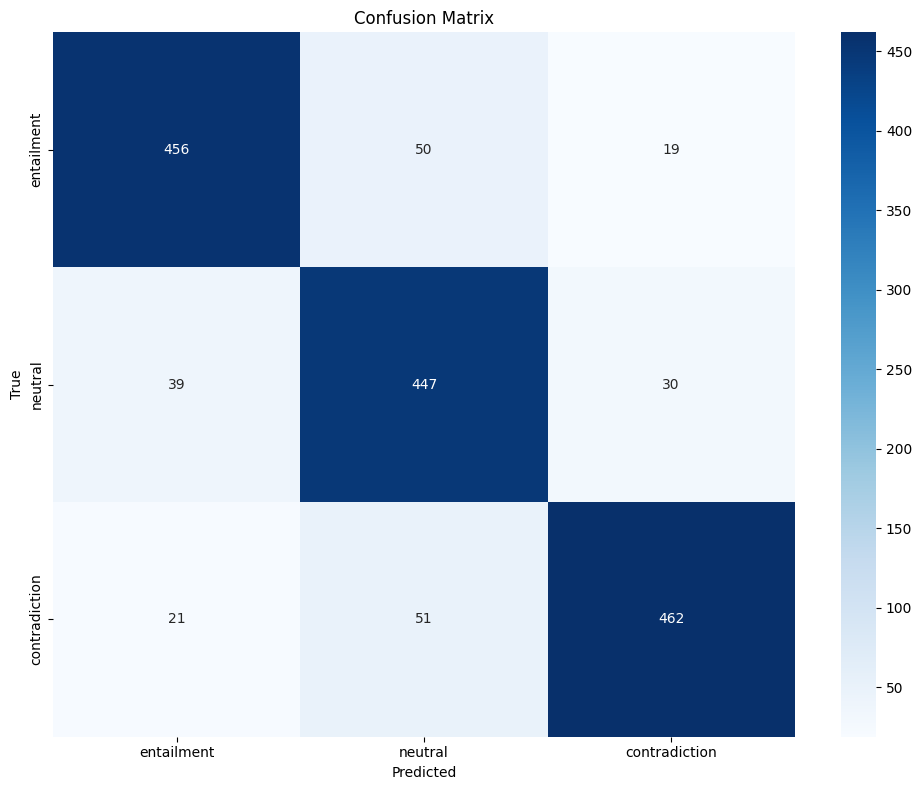

KeyError: "Column label not in the dataset. Current columns in the dataset: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'text', 'input_ids', 'token_type_ids', 'attention_mask']"

In [ ]:
from sklearn.metrics import confusion_matrix

english_pred_labels = np.argmax(english_preds.predictions, axis=1)
multilingual_pred_labels = np.argmax(multilingual_preds.predictions, axis=1)

combined_pred_labels = np.concatenate([english_pred_labels, multilingual_pred_labels])

combined_ids = np.concatenate([english_data_dict['test']['id'], multilingual_data_dict['test']['id']])

# Create confusion matrices
def plot_confusion_matrix(predictions, labels):
    class_names = ["entailment", "neutral", "contradiction"]
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Visualize confusion matrices for both models
english_val_preds = english_trainer.predict(english_data_dict['val'])
multilingual_val_preds = multilingual_trainer.predict(multilingual_data_dict['val'])

english_val_pred_labels = np.argmax(english_val_preds.predictions, axis=1)
multilingual_val_pred_labels = np.argmax(multilingual_val_preds.predictions, axis=1)

plot_confusion_matrix(english_val_pred_labels, english_data_dict['val']['label'])
plot_confusion_matrix(multilingual_val_pred_labels, multilingual_data_dict['val']['label'])

def analyze_by_language(predictions, labels, languages):
    lang_results = {}

    # Get unique languages
    unique_langs = set(languages)

    for lang in unique_langs:
        # Get indices for this language
        lang_indices = [i for i, l in enumerate(languages) if l == lang]

        # Get predictions for this language
        lang_preds = [predictions[i] for i in lang_indices]
        lang_labels = [labels[i] for i in lang_indices]

        # Calculate accuracy for this language
        correct = sum(1 for p, l in zip(lang_preds, lang_labels) if p == l)
        accuracy = correct / len(lang_indices) if lang_indices else 0

        lang_results[lang] = {
            "samples": len(lang_indices),
            "accuracy": accuracy
        }

    # Visualize
    plt.figure(figsize=(12, 6))
    langs = list(lang_results.keys())
    accuracies = [lang_results[lang]["accuracy"] for lang in langs]
    sample_counts = [lang_results[lang]["samples"] for lang in langs]

    # Sort by accuracy
    sorted_indices = np.argsort(accuracies)
    sorted_langs = [langs[i] for i in sorted_indices]
    sorted_accs = [accuracies[i] for i in sorted_indices]
    sorted_counts = [sample_counts[i] for i in sorted_indices]

    bars = plt.bar(sorted_langs, sorted_accs, color='skyblue')

    # Add sample counts
    for i, (bar, count) in enumerate(zip(bars, sorted_counts)):
        plt.text(i, bar.get_height() + 0.01, f'n={count}',
                ha='center', va='bottom', fontsize=9)

    plt.axhline(y=sum(accuracies)/len(accuracies), color='r', linestyle='--',
               label=f'Average: {sum(accuracies)/len(accuracies):.3f}')

    plt.xlabel('Language')
    plt.ylabel('Accuracy')
    plt.title('Model Performance by Language')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.tight_layout()
    plt.savefig('performance_by_language.png')
    plt.show()

    return lang_results

# Analyze each model's performance by language
english_by_lang = analyze_by_language(
    english_pred_labels,
    english_data_dict['test']['label'],
    english_data_dict['test']['lang_abv']
)

multilingual_by_lang = analyze_by_language(
    multilingual_pred_labels,
    multilingual_data_dict['test']['label'],
    multilingual_data_dict['test']['lang_abv']
)


submission_df = pd.DataFrame({
     'prediction': combined_pred_labels
})

submission_df.to_csv('submission.csv', header=True, index=False)